# Machine Learning Waterbody Identification
### CSME 202 Final Project


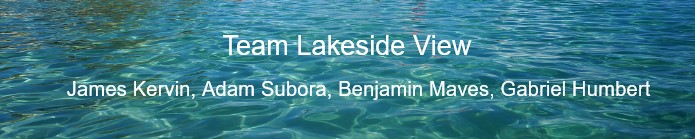

### Goals:

This project sets out to answer what machine learning method is best at classifying if a pixel is or isn't water in an image. Specficially this project constructs two perceptrons and two Support Vector Machines (SVM) and compares the efficency of each.

**Libraries need for this project**

In [1]:
#import pyplot for plotting
import matplotlib.pyplot as plt

#import numpy for array manipulation
import numpy as np

#import rasterio, a package that allows for multi-band image manipulation
import rasterio as rio

#import Resampling, allowing us to downsample images for faster processing
from rasterio.enums import Resampling

#import earthpy, allowing for easy RGB plotting of multi-band images
import earthpy.plot as ep

#import pandas, mainly used for ease of indexing data in testing
import pandas as pd

#import time (for timers) and os (to grab files in a folder)
import time
import os


#for displaying and resizing
from PIL import Image as PIL_im

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


%matplotlib inline

## NIR Perceptron Method

The first method tested is a perceptron that uses RGB, but also Near Infrared (NIR). Cameras that have all 4 of these sensors (CNIR sensors) are not as common as RBG sensors, but are often used by the government for agricultural purposes and most modern aerial imagery will have a dedicated NIR band. For this, we used imagery from the Michigan Public Imagery server.

Since this data does not have the labels necessary, we created them using the current industry standard for aerial water detection called Normalized Water Difference Index (NWDI). This index takes advantage of the interactions that the Green and NIR wavelengths have on water, and calculates their difference. This returns a 2-Dimensional binary "mask", where a pixel is a 1 if the difference is over a threshold, and 0 if it is not. In leiu of having a labeled data set, this is what we used for labels.

Because of this method, our accuracy rates will not be 100% accurate in themselves. The NWDI is not perfect, and sometimes will pick up noise like certain roads or rooftops, but overall it will catch all of the water bodies.

### Creating the Labels
This is the code we used to create the labels needed for CNIR datasets. It performs the NWDI calculations, then outputs them as 1-band binary rasters in .tiff format

In [2]:
#gather all data paths in list
image_list = os.listdir("mich_images/michimage")

#function that calculates the index, and returns a binary raster
def nwdi(array):
    array = (array - array.min()) / (array.max() - array.min())
    green = array[1]
    nir = array[3]
    nwdi = (green - nir)/(green + nir)
    nwdi_bin = np.zeros(nwdi.shape)
    for i in range(nwdi.shape[0]):
        for j in range(nwdi.shape[1]):
            if nwdi[i,j] > 0.1:
                nwdi_bin[i,j] = 1
    return nwdi_bin


#looping through all of the images, uses the nwdi function and applies it,
#and stores them in a list
labels = []
for i in range(len(image_list)):
    src = rio.open("mich_images/michimage/" + image_list[i])
    array = src.read()
    label = nwdi(array)
    labels.append(label.astype(np.uint8))
    
#creating output filenames for new rasters
outs = ['michlabel_1.tiff', 'michlabel_2.tiff', 'michlabel_3.tiff', 'michlabel_4.tiff', 'michlabel_5.tiff', 'michlabel_6.tiff']

#using rasterio, writing these binary label rasters to tiff files
for i in range(len(outs)):
    with rio.open('mich_images/michlabel/'+outs[i], 'w', width = 400, height = 400, dtype = np.uint8, count = 1, driver = 'GTiff') as dest:
        dest.write(labels[i], 1)

/home/kervinja/.local/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


### Model Creation
This class has several methods and attributes, but the main ones are load_images, train_test_split, fit, errors, and plot_test_image. This works much like the standard perceptron, but it has some added features.

First, it loads in all of the data with the option to resample the images. Downsampling allowed us to get much faster results while only losing very small water features.

Second, when it performs the train test split, it leaves the testing images as whole images, but converts the training images to 4 1-Dimensional arrays. This was done so that each image band (feature) could be one column of a data set. It also stacks the training images into one array, treating it as one large image. It does the same with the labels.

Third, it has a built in function to plot the test image (RGB), the predicted image, and the test label along with the accuracy score for each image.

In [3]:
class Water_Perceptron():
    '''class assumes: label in last column, bias weight is weight[0]'''
    
    def __init__(self, iterations = 100, learning_rate = 0.1):
        
        '''
        Creates a linear separable perceptron.
        
        Parameters:
            iterations = 100: # of fits the model will perform
            learning_rate = 0.1: Rate at which model will learn (0,1), smaller is slower
        '''
        self.iters = iterations
        self.rate = learning_rate
        
    def load_images(self, image_folder, label_folder, resampling_factor = 1):
        
        '''
        Loads images into perceptron. Assumes images and labels are in separate folder with no other files inside.
        
        Parameters:
            image_folder: (str) path to image folder
            label_folder: (str) path to label folder
            resampling_factor = 1: Amount of resampling to perform on images. <1 will be lower res, >1 will be higher res
            
        '''
        self.rsf = resampling_factor
        self.im_list = os.listdir(image_folder)
        self.lab_list = os.listdir(label_folder)
        self.images = []
        self.labels = []
        
        for i in range(len(self.im_list)):
            src_im = rio.open(image_folder + '/' + self.im_list[i])
            src_lab = rio.open(label_folder + '/' + self.lab_list[i])
            
            self.images.append(src_im.read(
                out_shape = 
                (
                    src_im.count,
                    int(src_im.height * self.rsf),
                    int(src_im.width * self.rsf)
                ),
                resampling = Resampling.average))
            
            self.labels.append(src_lab.read(                
                out_shape = 
                (
                    src_lab.count,
                    int(src_lab.height * self.rsf),
                    int(src_lab.width * self.rsf)
                ),
                resampling = Resampling.average))
            
            
    def train_test_split(self, no_of_train_images):
        
        '''
        Divides images into train test split and creates training data set. 
        
        Parameters:
            no_of_training_images: The number of images in the image set to use as training data.
        
        '''
        
        self.no_train = no_of_train_images
        self.training_images = np.hstack(self.images[:self.no_train])
        self.training_labels = np.hstack(self.labels[:self.no_train])
        self.testing_images = self.images[self.no_train:]
        self.testing_labels = self.labels[self.no_train:]
        
        def normalize(array):
            '''Turns RGB values into floats between 0 and 1'''
            return (array - array.min()) / (array.max() - array.min())
        
        self.data_dict = {
            'blue' : normalize((self.training_images)[0]).flatten(),
            'green' : normalize((self.training_images)[1]).flatten(),
            'red' : normalize((self.training_images)[2]).flatten(),
            'nir' : normalize((self.training_images)[3]).flatten(),
            'labels' : (self.training_labels).flatten()
        }
        
        self.pd_data = pd.DataFrame(self.data_dict)
        self.data = np.array(self.pd_data)
        
        
        #Set weights
        self.weights = np.ones(self.data[0].shape)
                        
        #Define self.features list of feature vectors in init
        self.features = []

        for i in range(len(self.data)):

            ind_feature = [1]

            for j in range(len(self.data[0]) - 1):
                ind_feature.append(self.data[i][j])

            self.features.append(np.array(ind_feature))        
            
    def plot_train(self):
        '''Plots training rgb image and label'''
        fig, ax = plt.subplots(1, 2, figsize = (10,10))
        ep.plot_rgb((self.training_images), ax = ax[0])
        ax[0].set_title("RGB Image")
        ax[1].imshow((self.training_labels).squeeze(), cmap = 'Greys')
        ax[1].set_title("Labeled Image")
        plt.suptitle(f"Resampling Factor: {self.rsf}")
        
    def predict(self, feature_row):
        '''
        Takes a row from feature set and predicts label value from dot multiplication of weight and feature vectors
        '''
        #predict label based on features

        #pull vectors from list of feature vectors
        feature_vector = self.features[feature_row]

        #dot product of weight vector and feature vector
        prediction = np.dot(self.weights, feature_vector)

        #return binary outcome of prediction calculation
        if prediction >= 0:
            return 1
        else: 
            return 0  
   
    def fit(self):
        '''
        Perform a fit of the training data {iterations} number of times. This performs the update rule and sets the bias and weights for testing
        '''
        
        self.start = time.time()
        
        for itr in range(self.iters):
            #update 'iter' amount of times
            
            for i in range(len(self.data)):
                #loop through all rows of data
                
                #Define Feature Vector [1, x1, x2, ..., xn]
                feature = self.features[i]
                
                #Define Class given 
                class_label = self.data[i][-1]
                
                #Get Prediction
                prediction_label = self.predict(i)
                
                #Perform Update Rule
                for j in range(len(self.weights)):
                    self.weights[j] = self.weights[j] + (self.rate * (class_label - prediction_label) * feature[j])
                    
        self.stop = time.time()

    
    def get_bias(self):
        '''
        Returns Bias Weight
        '''
        return self.weights[0]
    
    def get_weights(self, index):
        '''
        Returns Weights
        
        Parameters:
            index: index of weight vector
            
        Returns:
            weight at specified index
        '''
        return self.weights[index]
    
    def errors(self):
        
        '''
        Calculates Statistics for training images.
        
        Returns:
            Error Count
            Accuracy Score in %
            Bias Weight
            Weights
            Time Elapsed for fit
        '''
        self.classified = self.training_images[0]*self.get_weights(1) + self.training_images[1]*self.get_weights(2) + self.training_images[2]*self.get_weights(3) + self.training_images[3]*self.get_weights(4) + self.get_bias()
        
        self.classified_bin = np.zeros(self.classified.shape)

        for i in range(self.classified.shape[0]):
            for j in range(self.classified.shape[1]):
                if self.classified[i,j] > 0:
                    self.classified_bin[i,j] = 1
                    
        self.classified_f = self.classified_bin.flatten()
        
        self.num_errors = 0
        
        #Define predictions for each row
        for i in range(len(self.data)):
            class_label = self.data[i][-1]
            predicted_label = self.classified_f[i]
            
            #Check prediction against known class label
            if predicted_label != class_label:
                self.num_errors += 1
        
        print("\nError Count:", self.num_errors)
        print("\nScore:", 1 - (self.num_errors/len(self.data)))
        print("\nWeights:\n", self.weights[1:])
        print("\nBias Weight:", self.weights[0])
        print("\nTime Elapsed:", (self.stop - self.start), 'Seconds')
        
    def get_error(self):
        '''Returns error count for training data'''
        return self.num_errors
    
    def plot_test_image(self, image_no):
        '''
        Plots test images (rgb), the predicted classification, and test label image. Displays accuracy of perceptron compared to label.
        
        Parameters:
            image_no: The index of the image to display. Ranges from 0 to (total # of images uploaded - # used for training)
        '''
        test_class = self.testing_images[image_no][0]*self.get_weights(1) + self.testing_images[image_no][1]*self.get_weights(2) + self.testing_images[image_no][2]*self.get_weights(3) + self.testing_images[image_no][3]*self.get_weights(4) + self.get_bias()
        
        test_class_bin = np.zeros(test_class.shape)
        
        for i in range(test_class.shape[0]):
            for j in range(test_class.shape[1]):
                
                if test_class[i,j] > 0:
                    test_class_bin[i,j] = 1
        
        test_error = 0
        test_class_f = test_class_bin.flatten()
        test_labeled_f = self.testing_labels[image_no].squeeze().flatten()
        
        for i in range(len(test_class_f)):
            if test_class_f[i] != test_labeled_f[i]:
                test_error += 1
        test_score = round((1 - (test_error/len(test_class_f))) * 100, 2)
                    
        fig, ax = plt.subplots(1, 3, figsize = (15,6))
        
        ep.plot_rgb(self.testing_images[image_no], ax = ax[0])
        ax[0].set_title("RGB Test Image")
        ax[1].imshow(test_class_bin, cmap = 'Greys')
        ax[1].set_title("Classified Test Image")
        ax[2].imshow(self.testing_labels[image_no].squeeze(), cmap = "Greys")
        ax[2].set_title("Label")
        plt.suptitle(f"Accuracy Score: {test_score}%")

### Creating the CNIR Perceptron
We used 2000 iterations and a Learning Rate of 0.001 for this perceptron.

In [4]:
p = Water_Perceptron(2000, 0.001)

### Loading in Images
These paths contain the images and the labels created above. For the final test, we used a downsampling rate of 0.5, turning our original images from 400x400 pixels to 200x200 pixels which cut the processing time nearly in half.

In [5]:
p.load_images('mich_images/michimage', 'mich_images/michlabel', 0.5)

/home/kervinja/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### Splitting the data and performing the fit
We used 2 images for training, and 4 for testing. Then the data was fit and statistics were printed out, along with plotting the training images and their corresponding labels for better interpretation of what the NDWI looks like.

In [ ]:
p.train_test_split(2)
p.fit()
p.errors()

In [ ]:
p.plot_train()

### Plotting the test data
We then plotted the 4 test images to test the model with new data.

In [ ]:
p.plot_test_image(0)

In [ ]:
p.plot_test_image(1)

In [ ]:
p.plot_test_image(2)

In [ ]:
p.plot_test_image(3)

## Conclusions for the NIR perceptron
This method worked very well, with an average accuracy of 98.20%. We expected this to work well because light begins to really interact with water differently than land in the NIR frequency spectrum. This made the data more linearly separable than just RGB data, but still allowed for the RGB bands to contribute to the separation as features.

Our model correctly classified all the waterbodies we tested with this method, and even properly classified some of the NWDI noise as land. If we had 100% accurate labels, we think our accuracy score would be even higher.

## RGB Perceptron Method

In atempt to see if the same level of accuracy can be attained using less features a a perceptron that uses only the RGB values was created. Not only does using the RGB values reduce complexity it would also open the project up to a much larger set of data. RGB cameras are widely available and so are RGB images of water bodies where NIR cameras are, in comparison,  much less common. To do this a new perceptron class is created with a much simpler and straightforward process.</br>
To do this a new class was created with a smaller set of operations to reduce complexity. 

In [ ]:
class Perceptron():
    '''class assumes: label in last column, bias weight is weight[0]'''

    def __init__ (self, labeled_data, iters, learning_rate):
        '''
        Function creates a linear perceptiron:
        labeld_data: 
        iters: 
        learning_rate: 
        '''
        # attributes now are: data, weights, iterations, learning rate
        
        self.data = labeled_data
        
        # set two attributes: data, weights
        self.weights = np.array([1.0]*(len(self.data[0])))
        
        self.iterations = iters
        
        self.learning_rate = learning_rate
        
        
        
    def predict(self, feature_set, HasKey = True):
        '''This is used to predict values'''
        
        if HasKey:
            feature_set = feature_set[:-1]
        
        #run error checking
        if len(self.weights) < 2:
             raise Exception("error in weight length")
        if not (len(self.weights[1:]) == len(feature_set)):
            print(self.weights[1:])
            print(feature_set)
            raise Exception("feature set and wieghts of uneven length")
        
        #produce dot product
        total = self.weights[0] #initate the total with the bias weight
        total += np.dot(feature_set, self.weights[1:])

        if total > 0:
            return 1
        else:
            return -1
        
        
    def fit(self):
        ''' Creates the fitted line, dependent on params in initation
        assumes label is in the last column
        
        Process for fit:
        for all iterations
            for each row in the data
                find the update value, changes the weights (including bias weight)
        ''' 
        
        for i in range(0, self.iterations):
            for row in self.data:
                
                #get predicted value
                pred = self.predict(row)
                
                #get the correct/true label assuming its at the end
                class_col = row[-1]
                
                #use function to find update value
                update_value = self.learning_rate* (class_col - pred)
                
                #set each weight by adding with the update value
                self.weights[0] = self.weights[0] +update_value
                
                for j in range(1, len(row)):
                    update_sum = update_value*row[j]
                    
                    self.weights[j] = self.weights[j] +update_sum
    
    
    
    
    def errors(self):
        '''Returns integers of number of errors with regard to the 
        current model'''
        
        # how many rows of the data don't match the provided label?
        
        errors = 0
        
        #go through each row
        for row in self.data:
            #get predicted value
            pred = self.predict(row)

            #get the correct/true label
            class_col = row[-1]
            
            #compare the two results
            if not pred ==  class_col:
                errors += 1
                
        print("\nError Count:", errors)
        print("\nScore:", 1 - (errors/len(self.data)))
 
    
    def TestImage(self, image_features, w, h):
        self.data = image_features
        
        #step through each pixel and get all of the predicitons
        labeled_array = []
        for i in range(0, len(image_features)):
            pixel = image_features[i]
            result = self.predict(pixel)
            labeled_array.append(result)

        #Now reconstruct the array to an image
        image = []

        for i in range(0, w):
            #create new row
            row = []
            for j in range(i*h, i*h+h):
                row.append(labeled_array[j])
            image.append(row)

        return image

With the machine learning model created the RGB pictures must now be brough in. The function below is used to simplify the image collection and standerdize the resizing process. The resize coefficient is used as a percentage of each axis that remains in the image after resizing.
</br>
This function was chosen to stay outside of the class as brining in images and resizing them in not inherent to a perceptron but rather this project

In [ ]:
#bring in each image as a matrix

def BringInImage(image_path, key_path = None, rsf = 1, show = True):
    im = PIL_im.open(image_path)
    
    size_arr_org = np.array(im)
    size = (int(len(size_arr_org[0])*rsf ), int(len(size_arr_org)*rsf ))
    im = im.resize(size)
    
    if key_path:
        key = PIL_im.open(key_path)
        key = key.resize(size)
    
    
    if show:
        #Display them
        f = plt.figure()
        f.set_figwidth(20)
        f.set_figheight(20)
        
        plt.subplot(1,2,1)
        plt.title("Input Image")
        plt.imshow(im)

        plt.subplot(1,2,2)
        plt.title("Image Key")
        plt.imshow(key)
    
    im = np.array(im)
    key = np.array(key)
    return  im, key

In [ ]:
Image, key_RGB = BringInImage(r"Images/water_body_1.jpg", r"Keys/water_body_1.jpg", 0.1)

With the images collected the images must be broken down into its features. For this perceptron the red, green, blue, teal, and white of each pixel are used as features. The additional values of teal and white were chosen as the water is expected to occasionally have glare or a more teal than blue color.


Additional to the features collected in the original image is the key which must be broken down into 1 and -1 values. For each feature line the key value is added onto the end to be used in fitting the image.

In [ ]:
def GetFeatures(RGB_image, RGB_key_matrix):
    
    #this is used to create a matrix of 1's and 0's
    key = np.zeros((len(RGB_key_matrix), len(RGB_key_matrix[0])))
    
    #This is used to store all features and the label at index[-1]
    featrues_array = []
    
    for i in range(0, len(RGB_image)):
        for j in range(0, len(RGB_image[0])):
            R, G, B = RGB_image[i,j]
            
            #convert data types to proctect against overflow
            R = int(R)
            G = int(G)
            B = int(B)
            
            T = G+B
            
            W = G+R+B
            
            
            Pixel_features = [R, G, B, T, W]
            
            
            #find the label of it 
            Key_pixel = np.sum(RGB_key_matrix[i, j])
            if Key_pixel > 500:
                key[i,j] = 1
                Pixel_features.append(-1)
            else:
                key[i, j] = -1
                Pixel_features.append(1)
            
            featrues_array.append(Pixel_features)
                
    return key, featrues_array

In [ ]:
key, Image_features = GetFeatures(Image, key_RGB)
plt.imshow(key)

### Create perceptron
With the key and image features collected the perceptron can now be trained. To do this the fit method is called which will step through the number of itterations specified when creating the perceptron. Once finished the newly trained perceptron can be tested with the train data to see accuracy

In [ ]:
p = Perceptron(Image_features, 20**2, 1)
p.fit()
p.errors()

In [ ]:
Pre_image = p.TestImage(Image_features, len(Image), len(Image[0]))
plt.imshow(Pre_image)

### Test with new images
Now with the trained perceptron, the perceptron can be tested with new data to see how it will react when presented with unforseen data

In [ ]:
Image, key_RGB = BringInImage(r"Images/water_body_2.jpg", r"Keys/water_body_2.jpg", 0.1)

In [ ]:
key, Image_features = GetFeatures(Image, key_RGB)

In [ ]:
Pre_image = p.TestImage(Image_features, len(Image), len(Image[0]))
p.errors()
plt.imshow(Pre_image)

In [ ]:
Image, key_RGB = BringInImage(r"Images/water_body_3.jpg", r"Keys/water_body_3.jpg", 0.3)
key, Image_features = GetFeatures(Image, key_RGB)
Pre_image = p.TestImage(Image_features, len(Image), len(Image[0]))
p.errors()
plt.imshow(Pre_image)

In [ ]:
Image, key_RGB = BringInImage(r"Images/water_body_5.jpg", r"Keys/water_body_5.jpg", 0.3)
key, Image_features = GetFeatures(Image, key_RGB)
Pre_image = p.TestImage(Image_features, len(Image), len(Image[0]))
p.errors()
plt.imshow(Pre_image)

## Conclusion For RGB Perceptron

From the images above the RGB method for determining the placment of water is not very accurate. While this method is very fast at annalyizing the image and returning a new image, it lacks in accuracy. In general this model should not be used as every pixel contains some level of all of the features making the data not linealry seperable

## Near Infrared Support Vector Machine

Next we created an SVM which uses RGB values as well as near IR values as it's features. Near infrared data comes from the Michigan government but is much more limited than just RGB data which is widely available. Here we created an SVM class to try to identify water pixels.

In [ ]:
class Water_SVM():
    

        
    def set_train_image(self, train_image_path, train_label_path, resample_factor = 1):
                
        self.rsf = resample_factor
        
        #Open both Training Image and Training "labels" and resample if specified 
        with rio.open(train_image_path) as training_dataset:
            self.img = training_dataset.read(
                out_shape = 
                (
                    training_dataset.count,
                    int(training_dataset.height * self.rsf),
                    int(training_dataset.width * self.rsf)
                ),
                resampling = Resampling.average)
        
        with rio.open(train_label_path) as label_dataset:
            self.labeled_img = label_dataset.read(
                out_shape = 
                (
                    label_dataset.count,
                    int(label_dataset.height * self.rsf),
                    int(label_dataset.width * self.rsf)
                ),
                resampling = Resampling.average)
        print(self.labeled_img.shape, self.img.shape)
        #Make function to normalize image (convert from RGB to Float)
        def normalize(array):
            return (array - array.min()) / (array.max() - array.min())
            
        #Define Panchromatic dataset which will be used as a feature of "whiteness"
        self.pan = self.img[0] + self.img[1] + self.img[2]
        print(normalize(self.img[0]).flatten().shape,normalize(self.img[1]).flatten().shape, normalize(self.img[2]).flatten().shape,
             normalize(self.pan).flatten().shape, self.labeled_img.flatten().shape)
        #Create data set of flattened color, nir, pan arrays and labels
        self.data_dict = {
            'blue' : normalize(self.img[0]).flatten(),
            'green' : normalize(self.img[1]).flatten(),
            'red' : normalize(self.img[2]).flatten(),
            'nir' : normalize(self.img[3]).flatten(),
            'pan' : normalize(self.pan).flatten(),
            'labels' : self.labeled_img.flatten()
        }
        
        self.pd_data = pd.DataFrame(self.data_dict)
        self.data = np.array(self.pd_data)
        
        
            
    def plot_train(self):
        fig, ax = plt.subplots(1, 2, figsize = (15,6))
        ep.plot_rgb(self.img, ax = ax[0])
        ax[0].set_title("RGB Image")
        ax[1].imshow(self.labeled_img.squeeze(), cmap = 'Greys')
        ax[1].set_title("Labeled Image")
        plt.suptitle(f"Resampling Factor: {self.rsf}")
        
    def classifier(self):
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear','rbf']}
        self.tmp_labels = self.data[:,-1]
        self.tmp_vectors = self.data[:,:-1]
        self.clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
        self.clf = self.clf.fit(self.tmp_vectors, self.tmp_labels)
        print("Best estimator found by grid search:")
        print(self.clf.best_estimator_)
        print("Best parameters found by grid search:")
        print(self.clf.best_params_)
    def test(self, test_img_path, r_factor):
        
        self.test_rsf = r_factor # test image resizing factor
        #opening and resizing test image
        with rio.open(test_img_path) as testing_set:
            self.test_img = testing_set.read(
                out_shape = (
                    testing_set.count,
                    int(testing_set.height * self.test_rsf),
                    int(testing_set.width * self.test_rsf)
                ),
                resampling = Resampling.average)
        print(self.test_img.shape)
        def normalize(array):
            return (array - array.min()) / (array.max() - array.min())
            
        #Define Panchromatic dataset which will be used as a feature of "whiteness"
        self.pan = self.test_img[0] + self.test_img[1] + self.test_img[2]
        print(self.pan.shape)
        #Create data set of flattened color, nir, pan arrays and labels
        self.data_dict1 = {
            'blue' : normalize(self.test_img[0]).flatten(),
            'green' : normalize(self.test_img[1]).flatten(),
            'red' : normalize(self.test_img[2]).flatten(),
            'nir' : normalize(self.test_img[3]).flatten(),
            'pan' : normalize(self.pan).flatten()
        }
        
        self.pd_data1 = pd.DataFrame(self.data_dict1)
        self.data1 = np.array(self.pd_data1)
        print(self.data1.shape)
            
        #use classifier to predict test image
        self.pred_labels = self.clf.predict(self.data1)
        print(self.pred_labels.shape)
        self.pred_labels = np.array(self.pred_labels).reshape(self.test_img.shape[1],self.test_img.shape[2])
        print(self.pred_labels.shape)
        fig, ax = plt.subplots(1, 2, figsize = (15,6))
        
        ep.plot_rgb(self.test_img, ax = ax[0])
        ax[0].set_title("RGB Test Image")
        ax[1].imshow(self.pred_labels, cmap = 'Greys')
        ax[1].set_title("Classified Test Image")
        plt.suptitle(f"Resampling Factor: {self.test_rsf}")
        
    def get_accuracy(self, test_label_path):
        
        #open test labels in same shape as test image
        with rio.open(test_label_path) as testlab_set:
            self.test_label = testlab_set.read(
                out_shape = (
                    testlab_set.count,
                    int(testlab_set.height * self.test_rsf),
                    int(testlab_set.width * self.test_rsf)
                ),
                resampling = Resampling.average)
            
        errors = np.sum(abs(self.test_label - self.pred_labels)) #number of incorrectly labeld pixels

        accuracy = 1 - (errors / (self.test_label.size)) #percentage of correctly labeld pixels
        print('Image accuracy:', accuracy)
        
        fig, ax = plt.subplots(1, 2, figsize = (15,6))
        
        ax[0].imshow(self.test_label[0], cmap = 'Greys')
        ax[0].set_title("Test Labels")
        ax[1].imshow(self.pred_labels, cmap = 'Greys')
        ax[1].set_title("Classified Test Image")
        plt.suptitle(f"Resampling Factor: {self.test_rsf}")

In [ ]:
train_im1 = 'mich_images/michimage/michimage_1.tiff'
train_label1 = 'mich_images/michlabel/michlabel_1.tiff'

train_im2 = 'mich_images/michimage/michimage_2.tiff'
train_label2 = 'mich_images/michlabel/michlabel_2.tiff'

train_im3 = 'mich_images/michimage/michimage_5.tiff'
train_label3 = 'mich_images/michlabel/michlabel_5.tiff'

test_im1 = 'mich_images/michimage/michimage_3.tiff'
test_label1 = 'mich_images/michlabel/michlabel_3.tiff'

test_im2 = 'mich_images/michimage/michimage_4.tiff'
test_label2 = 'mich_images/michlabel/michlabel_4.tiff'

test_im3 = 'mich_images/michimage/michimage_6.tiff'
test_label3 = 'mich_images/michlabel/michlabel_6.tiff'

In [ ]:
SVM = Water_SVM()

In [ ]:
SVM.set_train_image(train_im2, train_label2, 0.3)

In [ ]:
SVM.plot_train()

In [ ]:
SVM.classifier()

In [ ]:
SVM.test(test_im1,1)

In [ ]:
SVM.get_accuracy(test_label1)

In [ ]:
SVM.test(test_im2,1)

In [ ]:
SVM.get_accuracy(test_label2)

## Conclusions for NIR SVM

From the above images, it is evident that the near infrared supprt vector machine is accurate at predicting where water is. The addition of the near infrared makes the data much more seperable and allows water pixels to be identified with a good accuracy.

## RGB SVM

We also created an SVM which included only the RGB values as features along with a white and teal feature. This data was much more widely accessable than the NIR data as any camera could take these images.

In [ ]:
class RGB_SVM():
    

        
    def set_train_image(self, train_image_path, train_label_path, resample_factor = 1):
                
        self.rsf = resample_factor
        
        self.im = PIL_im.open(train_image_path)
    
        size_arr_org = np.array(self.im)
        size = (int(len(size_arr_org[0])*self.rsf ), int(len(size_arr_org)*self.rsf ))
        self.im = self.im.resize(size)
    
        if train_label_path:
            self.key = PIL_im.open(train_label_path)
            self.key = self.key.resize(size)
    
    
    
        self.im = np.array(self.im)
        self.key = np.array(self.key)
        
        self.keys_array = np.zeros((len(self.key), len(self.key[0])))
    
    #This is used to store all features and the label at index[-1]
        self.features_array = []
    
        for i in range(0, len(self.key)):
            for j in range(0, len(self.key[0])):
                R, G, B = self.im[i,j]
            
            #convert data types to proctect against overflow
                R = int(R)
                G = int(G)
                B = int(B)
            
                T = G+B
            
                W = G+R+B
            
            
                Pixel_features = [R, G, B, T, W]
            
            
            #find the label of it 
                Key_pixel = np.sum(self.key[i, j])
                if Key_pixel > 500:
                    self.keys_array[i,j] = 1
                    Pixel_features.append(1)
                else:
                    self.keys_array[i, j] = 0
                    Pixel_features.append(0)
            
                self.features_array.append(Pixel_features)
                
        self.data = np.array(self.features_array)
        

            


        
        
            
    def plot_train(self):
        fig, ax = plt.subplots(1, 2, figsize = (15,6))
        ax[0].imshow(self.im)
        ax[0].set_title("RGB Image")
        ax[1].imshow(self.keys_array, cmap = 'Greys')
        ax[1].set_title("Labeled Image")
        plt.suptitle(f"Resampling Factor: {self.rsf}")
        
    def classifier(self):
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear']}
        self.tmp_labels = self.data[:,-1]
        self.tmp_vectors = self.data[:,:-1]
        self.clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
        self.clf = self.clf.fit(self.tmp_vectors, self.tmp_labels)
        print("Best estimator found by grid search:")
        print(self.clf.best_estimator_)
        print("Best parameters found by grid search:")
        print(self.clf.best_params_)
    def test(self, test_img_path, test_label_path, r_factor):
        
        self.test_rsf = r_factor
        
        self.im = PIL_im.open(test_image_path)
    
        size_arr_org = np.array(self.im)
        size = (int(len(size_arr_org[0])*self.test_rsf ), int(len(size_arr_org)*self.test_rsf ))
        self.im = self.im.resize(size)
    
        if test_label_path:
            self.key = PIL_im.open(test_label_path)
            self.key = self.key.resize(size)
    
    
    
        self.im = np.array(self.im)
        self.key = np.array(self.key)
        
        self.keys_array = np.zeros((len(self.key), len(self.key[0])))
    
    #This is used to store all features and the label at index[-1]
        self.features_array = []
    
        for i in range(0, len(self.key)):
            for j in range(0, len(self.key[0])):
                R, G, B = self.im[i,j]
            
            #convert data types to proctect against overflow
                R = int(R)
                G = int(G)
                B = int(B)
            
                T = G+B
            
                W = G+R+B
            
            
                Pixel_features = [R, G, B, T, W]
            
            
            #find the label of it 
                Key_pixel = np.sum(self.key[i, j])
                if Key_pixel > 500:
                    self.keys_array[i,j] = 1
                    Pixel_features.append(1)
                else:
                    self.keys_array[i, j] = 0
                    Pixel_features.append(0)
            
                self.features_array.append(Pixel_features)
        self.data1 = np.array(self.features_array)
            
        #use classifier to predict test image
        self.pred_labels = self.clf.predict(self.data1)
        print(self.pred_labels.shape)
        self.pred_labels = np.array(self.pred_labels).reshape(self.test_img.shape[1],self.test_img.shape[2])
        print(self.pred_labels.shape)
        fig, ax = plt.subplots(1, 2, figsize = (15,6))
        
        ep.plot_rgb(self.test_img, ax = ax[0])
        ax[0].set_title("RGB Test Image")
        ax[1].imshow(self.pred_labels, cmap = 'Greys')
        ax[1].set_title("Classified Test Image")
        plt.suptitle(f"Resampling Factor: {self.test_rsf}")
        
    def get_accuracy(self):
        
        
        
            
        errors = np.sum(abs(self.keys_array - self.pred_labels)) #number of incorrectly labeld pixels

        accuracy = 1 - (errors / (self.keys_array.size)) #percentage of correctly labeld pixels
        print('Image accuracy:', accuracy)
        
        fig, ax = plt.subplots(1, 2, figsize = (15,6))
        
        ax[0].imshow(self.keys_array[0], cmap = 'Greys')
        ax[0].set_title("Test Labels")
        ax[1].imshow(self.pred_labels, cmap = 'Greys')
        ax[1].set_title("Classified Test Image")
        plt.suptitle(f"Resampling Factor: {self.test_rsf}")

In [ ]:
train_rgb = 'Images/water_body_1.jpg'
train_rgb_lab = 'Keys/water_body_1.jpg'

In [ ]:
rgb = RGB_SVM()

In [ ]:
rgb.set_train_image(train_rgb, train_rgb_lab, 0.04)

In [ ]:
rgb.plot_train()

In [ ]:
rgb.classifier()

In [ ]:
test_im = 'Images/water_body_2.jpg'
test_lab = 'Keys/water_body_2lab.jpg'
rgb.test(test_im, test_lab, 1)

## Conclusion for SVM RGB

The RGB SVM is very innacurate. Although there is more availiable data, that does not make up for the lack of predictive ability from the RGB data without near infrared. Additionally, without near infrared included the training process is much longer.

# Conclusion

Through out this project the conclusion for each method is written, however from all it is clear that the best method is the method that uses NIR data. This is logical as each pixel will contain red, green, and blue, but the NIR data is very depedent on the reflectivness of the water. Below is a great comparision of all the models.

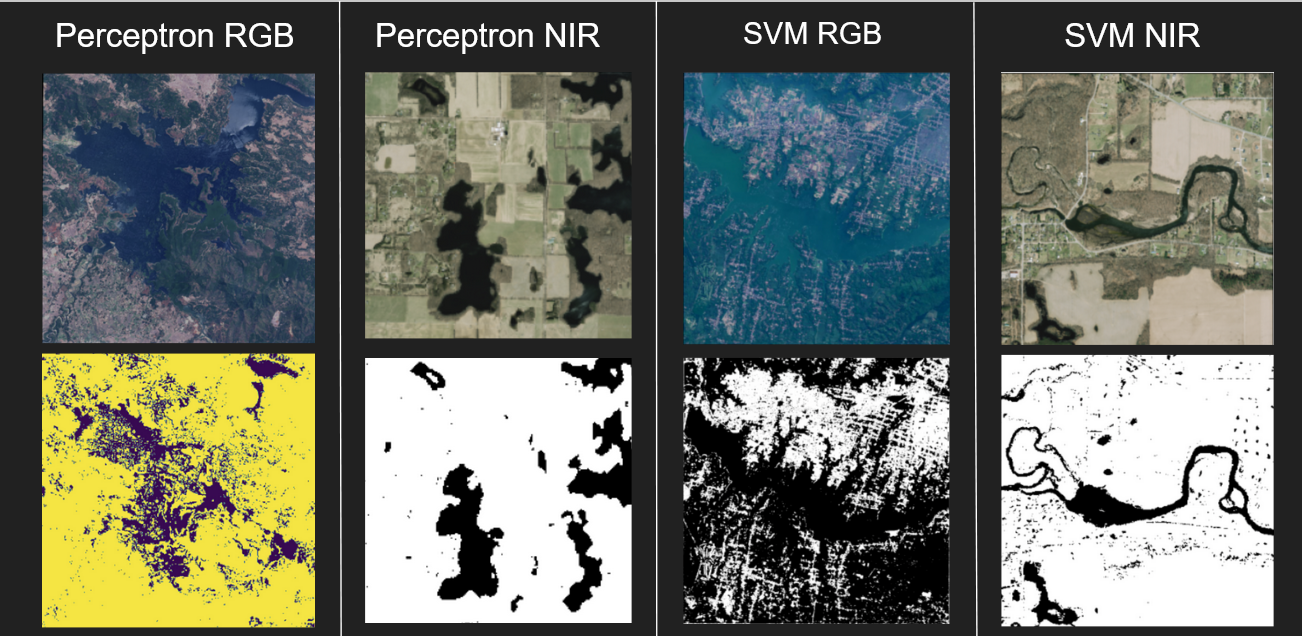